# PTA Pulsar-Term Sky Localization Analysis (Optimized)

This notebook is an optimized version that uses JAX JIT compilation for faster Fisher matrix calculations.

## Key Studies
1. **Pulsar ring localization**: ΔΩ vs angular separation from GW source
2. **All-sky maps**: Localization precision across the sky (HEALPix)
3. **Linked vs Decoupled**: Comparing interferometric (known phase) vs proximity-driven (unknown phase) regimes
4. **Distance uncertainty**: Effect of pulsar distance uncertainty on localization

## Setup

In [1]:
import jax
import jax.numpy as jnp
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import healpy as hp
import copy
from functools import partial

import utils
import constants as const

# Enable 64-bit precision
jax.config.update("jax_enable_x64", True)

# Plotting style
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.rcParams['font.family'] = 'STIXGeneral'
plt.rcParams['mathtext.fontset'] = 'stix'

def compute_sky_area(F, marginalized=True):
    """
    Computes sky localization area from Fisher matrix F.
    Uses diagonal pre-conditioning and principled rtol for robustness.
    """
    # Ensure symmetry
    F = (F + F.T) / 2.0
    
    if marginalized:
        # 1. Diagonal Pre-conditioning to handle varied parameter scales
        diag_F = jnp.diag(F)
        D_inv = 1.0 / jnp.sqrt(jnp.maximum(diag_F, 1e-30))
        F_scaled = D_inv[:, None] * F * D_inv[None, :]
        
        # 2. Principled rtol based on machine epsilon for float64
        eps = jnp.finfo(F.dtype).eps
        rtol = eps * F.shape[0]
        
        # 3. Pseudo-inverse of scaled matrix then rescale back
        F_inv_scaled = jnp.linalg.pinv(F_scaled, rtol=rtol)
        F_inv = D_inv[:, None] * F_inv_scaled * D_inv[None, :]
        
        det_val = jnp.linalg.det(F_inv[:2,:2])
        return (180/jnp.pi)**2 * 2*jnp.pi * jnp.sqrt(jnp.maximum(det_val, 1e-30))
    else:
        det_val = jnp.linalg.det(F[:2,:2])
        return (180/jnp.pi)**2 * 2*jnp.pi / jnp.sqrt(jnp.maximum(det_val, 1e-30))

# JIT-compile the sky area computation for faster repeated calls
compute_sky_area_jit = jax.jit(compute_sky_area, static_argnums=(1,))

# Timing helper for performance comparison
import time

class Timer:
    def __init__(self, name=''):
        self.name = name
    def __enter__(self):
        self.start = time.perf_counter()
        return self
    def __exit__(self, *args):
        self.elapsed = time.perf_counter() - self.start
        print(f"{self.name}: {self.elapsed:.2f}s")


## Binary and Timing Parameters

Define the GW source and PTA observation parameters.

In [2]:
# GW source parameters
pars = dict(
    cw_costheta=0.01,        # cos(dec) of GW source
    cw_phi=0.0,              # RA of GW source [rad]
    cw_cosinc=0.99,          # cos(inclination) - nearly face-on
    cw_log10_Mc=9.5,         # log10(chirp mass / Msun)
    cw_log10_fgw=-8.0,       # log10(GW frequency / Hz)
    cw_log10_dist=2.385,     # log10(luminosity distance / Mpc)
    cw_phase0=0.0,           # initial GW phase [rad]
    cw_psi=0.0,              # polarization angle [rad]
)

# PTA timing parameters: 10 years, 100 TOAs, 100 ns errors
t0 = 58000.0 * 86400.0  # start time [s]
t1 = t0 + 10.0 * 365.25 * 86400.0  # end time [s]
toas_new = jnp.linspace(t0, t1, 100)
toaerrs = jnp.full_like(toas_new, 1e-7)  # 100 ns

print(f"Observation span: {(t1-t0)/86400/365.25:.1f} years")
print(f"Number of TOAs: {len(toas_new)}")
print(f"TOA error: {toaerrs[0]*1e9:.0f} ns")

Observation span: 10.0 years
Number of TOAs: 100
TOA error: 100 ns


## Study 1: Sky Localization vs Pulsar-Source Separation

Generate pulsars in a ring around the GW source at varying angular separations.
Compute Fisher-matrix sky localization area (ΔΩ) for each configuration.

In [3]:
# Sweep angular separation from GW source
angles = jnp.linspace(1.0, 179.0, 50)
omega_sky = []           # unmarginalized
omega_sky_marg = []      # marginalized over other parameters
snrs = []

for ang in angles:
    # Generate ring of 20 pulsars at this angular separation
    psrs_ring = utils.pulsar_ring_generator(
        pars=pars, ang_radius=ang, npsrs=20,
        toas=toas_new, toaerrs=toaerrs, pdist=[1.0, 1e-3]  # 1 kpc ± 10 pc
    )
    
    # Create CW signal objects
    cw_signals = [utils.CW_Signal(psr=p, tref=p.toas[0], evolve=True) for p in psrs_ring]
    
    # Set up parameters with pulsar distances
    pars_copy = copy.deepcopy(pars)
    param_keys = list(pars_copy.keys()) + [p.name+'_pdist' for p in psrs_ring]
    param_vec = jnp.array(list(pars_copy.values()) + [0.0]*len(psrs_ring))
    pars_full = dict(zip(param_keys, param_vec))
    
    # Calibrate to SNR=10
    snr = jnp.sqrt(jnp.sum(jnp.stack([utils.computer_snr2(cw, pars_full, pterm=True) for cw in cw_signals])))
    snr = jnp.maximum(snr, 1e-6)  # Floor to prevent division issues
    snrs.append(snr)
    pars_full['cw_log10_dist'] = jnp.log10(snr * 10**pars['cw_log10_dist'] / 10.0)
    
    # Compute Fisher matrix with distance prior
    fishers = [utils.compute_fisher(cw, pars_full, pterm=True) for cw in cw_signals]
    prior = [0.0]*8 + [1.0 for _ in psrs_ring]
    F = jnp.sum(jnp.stack(fishers), axis=0) + jnp.diag(jnp.array(prior))
    
    # Numerical stability check
    cond = jnp.linalg.cond(F)
    rank = jnp.linalg.matrix_rank(F, tol=1e-10)
    if cond > 1e12 or rank < F.shape[0]:
        print(f"Warning at angle {ang:.1f}: cond={cond:.2e}, rank={rank}/{F.shape[0]}")
    
    # Sky localization area (safe calculation)
    omega_sky.append(compute_sky_area_jit(F, marginalized=False))
    omega_sky_marg.append(compute_sky_area_jit(F, marginalized=True))
omega_sky = jnp.array(omega_sky)
omega_sky_marg = jnp.array(omega_sky_marg)
snrs = jnp.array(snrs)

Warning at angle 1.0: cond=6.79e+12, rank=28/28
Warning at angle 4.6: cond=2.05e+13, rank=28/28
Warning at angle 8.3: cond=7.58e+13, rank=28/28
Warning at angle 11.9: cond=2.39e+15, rank=28/28
Warning at angle 15.5: cond=1.91e+14, rank=28/28
Warning at angle 19.2: cond=6.50e+14, rank=28/28
Warning at angle 22.8: cond=2.16e+15, rank=28/28
Warning at angle 26.4: cond=6.31e+14, rank=28/28
Warning at angle 30.1: cond=2.33e+15, rank=28/28
Warning at angle 33.7: cond=1.63e+15, rank=28/28
Warning at angle 37.3: cond=6.58e+16, rank=28/28
Warning at angle 41.0: cond=2.27e+15, rank=28/28
Warning at angle 44.6: cond=1.19e+16, rank=28/28
Warning at angle 48.2: cond=4.66e+15, rank=28/28
Warning at angle 51.9: cond=6.28e+15, rank=28/28
Warning at angle 55.5: cond=8.51e+15, rank=28/28
Warning at angle 59.1: cond=9.63e+15, rank=28/28
Warning at angle 62.8: cond=2.08e+16, rank=28/28
Warning at angle 66.4: cond=1.58e+16, rank=28/28
Warning at angle 70.0: cond=1.04e+17, rank=28/28
Warning at angle 73.7: 

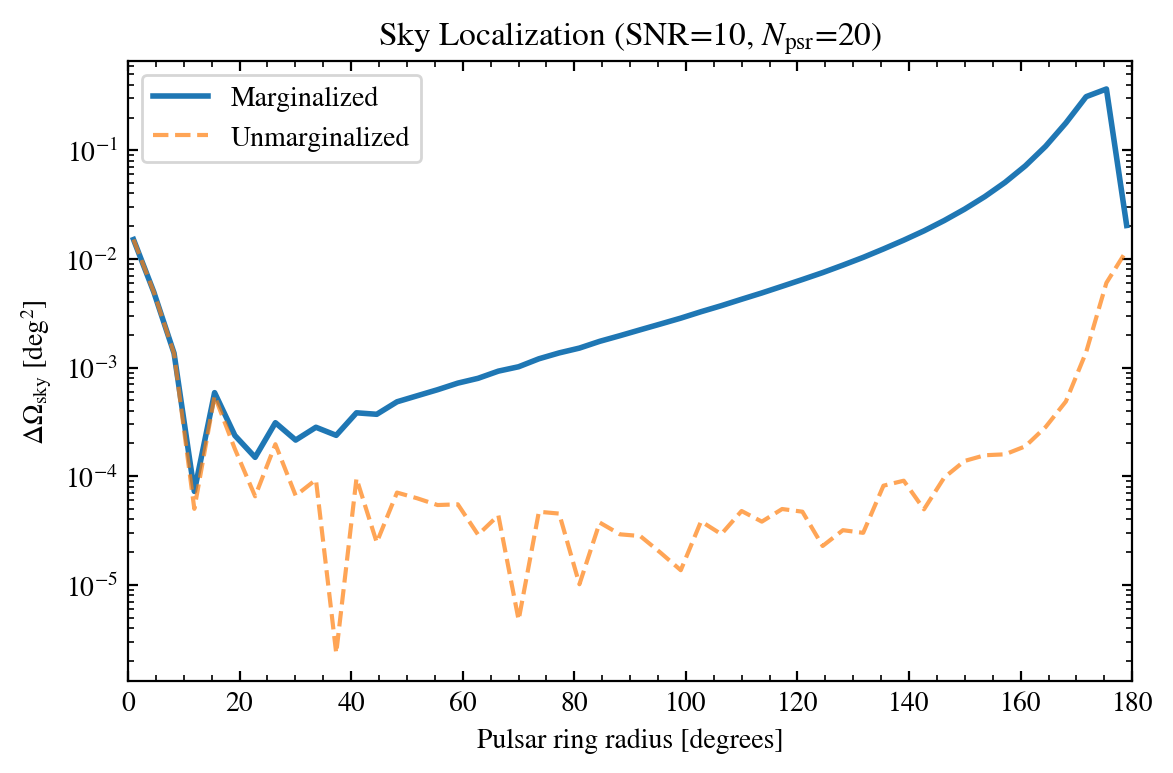

In [15]:
# Plot: ΔΩ vs ring angular radius
fig, ax = plt.subplots(figsize=(6, 4))

ax.semilogy(angles, omega_sky_marg, 'C0-', lw=2, label='Marginalized')
ax.semilogy(angles, omega_sky, 'C1--', lw=1.5, alpha=0.7, label='Unmarginalized')
#ax.plot(angles, omega_sky_marg, 'C0-', lw=2, label='Marginalized')
#ax.plot(angles, omega_sky, 'C1--', lw=1.5, alpha=0.7, label='Unmarginalized')

ax.set_xlabel('Pulsar ring radius [degrees]')
ax.set_ylabel(r'$\Delta\Omega_{\rm sky}$ [deg$^2$]')
ax.set_title(r'Sky Localization (SNR=10, $N_{\rm psr}$=20)')
ax.legend()
ax.set_xlim(0, 180)
ax.minorticks_on()
ax.tick_params(which='both', direction='in', top=True, right=True)

plt.tight_layout()
plt.savefig('outputs/localization_vs_ring_angle.pdf', bbox_inches='tight')
plt.show()

## Study 2: All-Sky Localization Map

Fix a pulsar ring around the North Pole and sweep the GW source location across the sky
to create an all-sky localization precision map.

In [ ]:
# HEALPix grid
nside = 16
npix = hp.nside2npix(nside)
theta_hp, phi_hp = hp.pix2ang(nside, np.arange(npix))
theta_hp = jnp.array(theta_hp)
phi_hp = jnp.array(phi_hp)

# Reference parameters for ring at North Pole
pars_map = dict(
    cw_costheta=0.999,
    cw_phi=0.0,
    cw_cosinc=0.99,
    cw_log10_Mc=9.5,
    cw_log10_fgw=-8.0,
    cw_log10_dist=2.385,
    cw_phase0=0.,
    cw_psi=0.,
)

print(f"HEALPix nside={nside}, npix={npix}")

In [ ]:
# Compute localization for each sky pixel
omega_map = []
ring_ang = 10.0  # fixed ring at 10 degrees from North Pole

for jj in range(npix):
    # Generate ring around North Pole
    psrs = utils.pulsar_ring_generator(
        pars=pars_map, ang_radius=ring_ang, npsrs=20,
        toas=toas_new, toaerrs=toaerrs, pdist=[1.0, 1e-3]
    )
    cws = [utils.CW_Signal(psr=p, tref=p.toas[0], evolve=True) for p in psrs]
    
    # Move GW source to this pixel
    pars_pix = copy.deepcopy(pars_map)
    pars_pix['cw_costheta'] = float(jnp.cos(theta_hp[jj]))
    pars_pix['cw_phi'] = float(phi_hp[jj])
    
    # Setup parameters
    param_keys = list(pars_pix.keys()) + [p.name+'_pdist' for p in psrs]
    param_vec = jnp.array(list(pars_pix.values()) + [0.0]*len(psrs))
    pars_full = dict(zip(param_keys, param_vec))
    
    # Calibrate SNR
    snr = jnp.sqrt(jnp.sum(jnp.stack([utils.computer_snr2(cw, pars_full, pterm=True) for cw in cws])))
    snr = jnp.maximum(snr, 1e-6)  # Floor to prevent division issues
    pars_full['cw_log10_dist'] = jnp.log10(snr * 10**pars_map['cw_log10_dist'] / 10.0)
    
    # Fisher matrix
    fishers = jnp.stack([utils.compute_fisher(cw, pars_full, pterm=True) for cw in cws])
    prior = [0.0]*8 + [1.0 for _ in psrs]
    F = jnp.sum(fishers, axis=0) + jnp.diag(jnp.array(prior))
    
    # Marginalized localization (safe calculation)
    omega_map.append(compute_sky_area_jit(F, marginalized=True))

omega_map = np.array(omega_map)
print(f"Min ΔΩ: {omega_map.min():.2f} deg², Max ΔΩ: {omega_map.max():.2f} deg²")

In [ ]:
# Plot HEALPix map
hp.mollview(
    omega_map,
    title=r'Sky Localization (SNR=10, $N_{\rm psr}=20$, $\\xi_{\rm ring}=10^\circ$)',
    unit=r'$\Delta\Omega_{\rm sky}$ [deg$^2$]',
    cmap='viridis',
    norm='hist'
)

# Overlay pulsar ring positions
psrs_ring = utils.pulsar_ring_generator(pars=pars_map, ang_radius=ring_ang, npsrs=20, toas=toas_new, toaerrs=toaerrs)
ras = np.degrees(np.array([p.ra for p in psrs_ring]))
decs = np.degrees(np.array([p.dec for p in psrs_ring]))
hp.projscatter(ras, decs, lonlat=True, s=30, color='white', marker='o', alpha=0.8)
hp.graticule()

plt.savefig('outputs/localization_skymap.pdf', bbox_inches='tight')
plt.show()

## Study 3: Linked vs Decoupled Pulsar-Term Phase

Compare sky localization under two regimes:
1. **Linked**: Pulsar-term phase determined by physics (frequency, chirp mass, distance, geometry) → interferometric
2. **Decoupled**: Pulsar-term phase treated as independent nuisance parameter → proximity-driven

In [17]:
# Compute both regimes across angular separations
angles_compare = jnp.linspace(1.0, 179.0, 50)
omega_linked = []
omega_decoupled = []

for ang in angles_compare:
    psrs = utils.pulsar_ring_generator(
        pars=pars, ang_radius=ang, npsrs=20,
        toas=toas_new, toaerrs=toaerrs, pdist=[1.0, 1e-5]
    )
    cws = [utils.CW_Signal(psr=p, tref=p.toas[0], evolve=True) for p in psrs]
    
    # Pre-compute pulsar-term phases
    pphases = []
    for p in psrs:
        _, _, cosMu = utils.create_gw_antenna_pattern(p._pos, jnp.arccos(pars['cw_costheta']), pars['cw_phi'])
        tp0 = -p.pdist[0] * const.kpc / const.c * (1 - cosMu)
        w0 = jnp.pi * 10**pars['cw_log10_fgw']
        mc = 10**pars['cw_log10_Mc'] * const.Tsun
        omega_p0 = w0 * (1 - 256/5 * mc**(5/3) * w0**(8/3) * tp0)**(-3/8)
        pphases.append(1/32 / mc**(5/3) * (w0**(-5/3) - omega_p0**(-5/3)))
    
    # --- LINKED (phase_free=False) ---
    param_keys_L = list(pars.keys()) + [p.name+'_pdist' for p in psrs]
    param_vec_L = jnp.array(list(pars.values()) + [0.0]*len(psrs))
    pars_L = dict(zip(param_keys_L, param_vec_L))
    snr_L = jnp.sqrt(jnp.sum(jnp.stack([utils.computer_snr2(cw, pars_L, pterm=True) for cw in cws])))
    snr_L = jnp.maximum(snr_L, 1e-6)  # Floor to prevent division issues
    pars_L['cw_log10_dist'] = jnp.log10(snr_L * 10**pars['cw_log10_dist'] / 10.0)
    F_L = jnp.sum(jnp.stack([utils.compute_fisher(cw, pars_L, pterm=True) for cw in cws]), axis=0)
    F_L += jnp.diag(jnp.array([0.0]*8 + [1.0]*len(psrs)))
    omega_linked.append(compute_sky_area_jit(F_L, marginalized=True))
    
    # --- DECOUPLED (phase_free=True) ---
    param_keys_D = list(pars.keys()) + [p.name+'_pdist' for p in psrs] + [p.name+'_pphase' for p in psrs]
    param_vec_D = jnp.array(list(pars.values()) + [0.0]*len(psrs) + pphases)
    pars_D = dict(zip(param_keys_D, param_vec_D))
    pars_D['cw_log10_dist'] = pars_L['cw_log10_dist']
    F_D = jnp.sum(jnp.stack([utils.compute_fisher(cw, pars_D, pterm=True) for cw in cws]), axis=0)
    F_D += jnp.diag(jnp.array([0.0]*8 + [1.0]*len(psrs) + [0.0]*len(psrs)))  # flat prior on phase
    omega_decoupled.append(compute_sky_area_jit(F_D, marginalized=True))

omega_linked = jnp.array(omega_linked)
omega_decoupled = jnp.array(omega_decoupled)

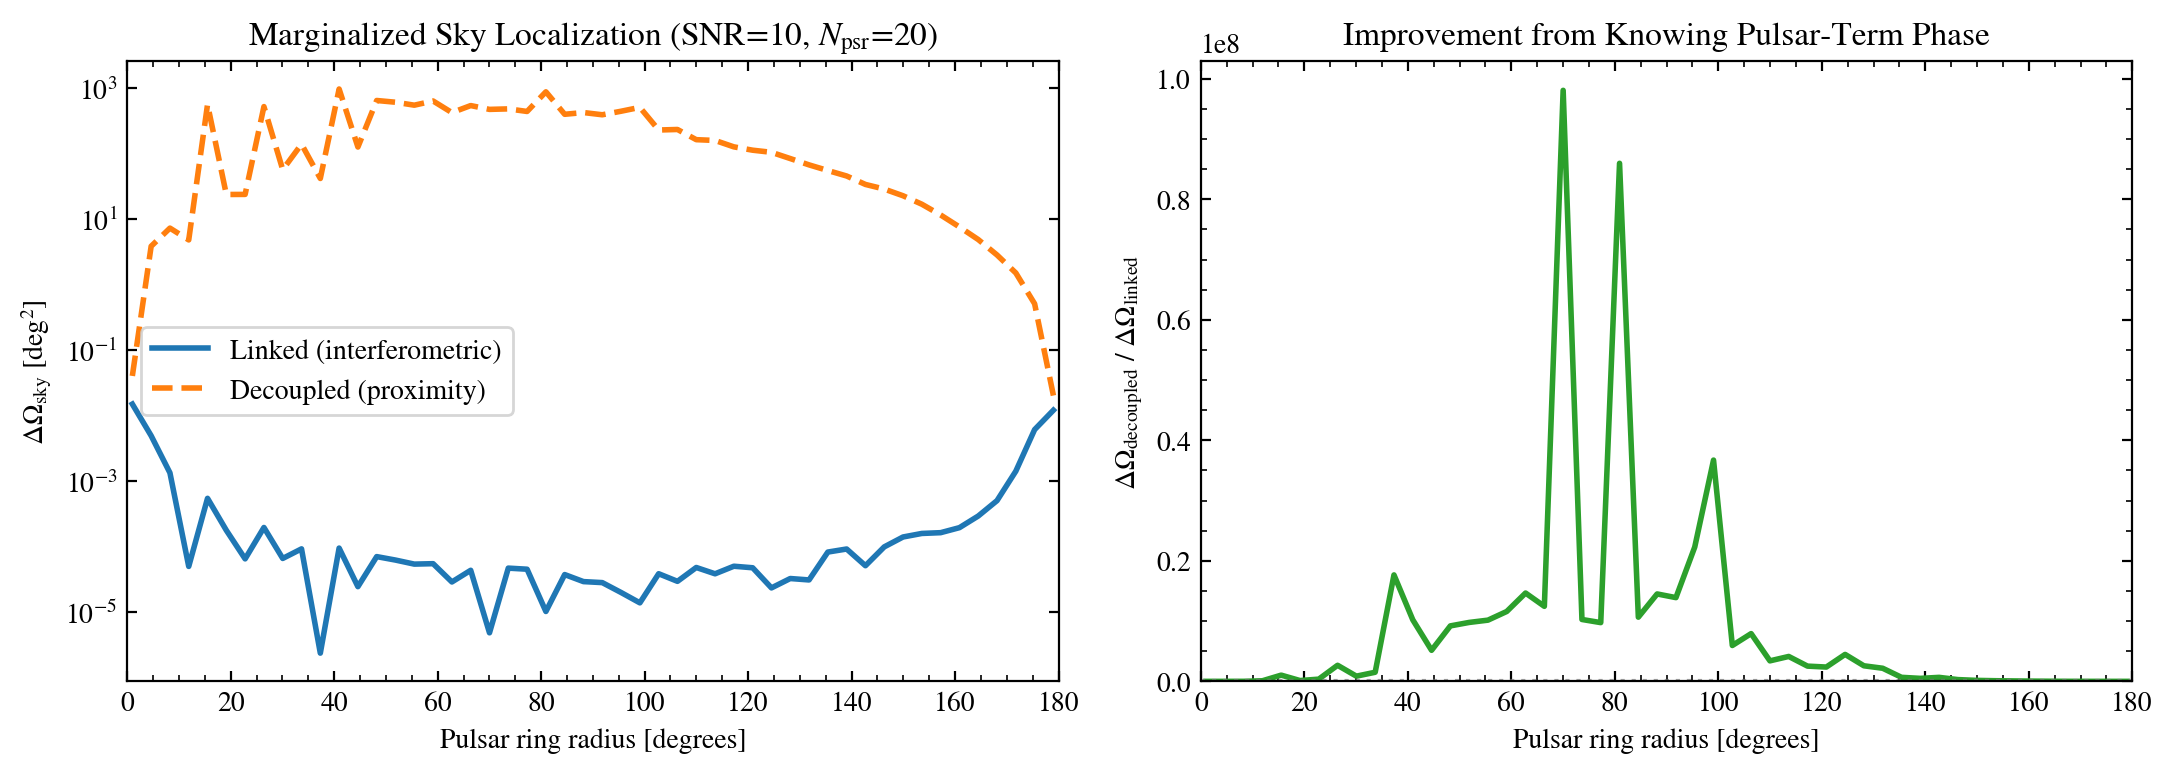

Max improvement: 98097745.8x at 70 degrees


In [18]:
# Plot comparison
fig, axes = plt.subplots(1, 2, figsize=(11, 4))

# Left: Localization area
ax = axes[0]
ax.semilogy(angles_compare, omega_linked, 'C0-', lw=2, label='Linked (interferometric)')
ax.semilogy(angles_compare, omega_decoupled, 'C1--', lw=2, label='Decoupled (proximity)')
ax.set_xlabel('Pulsar ring radius [degrees]')
ax.set_ylabel(r'$\Delta\Omega_{\rm sky}$ [deg$^2$]')
ax.set_title(r'Marginalized Sky Localization (SNR=10, $N_{\rm psr}$=20)')
ax.legend()
ax.set_xlim(0, 180)
ax.minorticks_on()
ax.tick_params(which='both', direction='in', top=True, right=True)

# Right: Improvement factor
ax = axes[1]
improvement = omega_decoupled / omega_linked
ax.plot(angles_compare, improvement, 'C2-', lw=2)
ax.axhline(1.0, ls=':', color='gray', alpha=0.7)
ax.set_xlabel('Pulsar ring radius [degrees]')
ax.set_ylabel(r'$\Delta\Omega_{\rm decoupled}$ / $\Delta\Omega_{\rm linked}$')
ax.set_title('Improvement from Knowing Pulsar-Term Phase')
ax.set_xlim(0, 180)
ax.set_ylim(0, None)
ax.minorticks_on()
ax.tick_params(which='both', direction='in', top=True, right=True)

plt.tight_layout()
plt.savefig('outputs/linked_vs_decoupled.pdf', bbox_inches='tight')
plt.show()

print(f"Max improvement: {improvement.max():.1f}x at {angles_compare[jnp.argmax(improvement)]:.0f} degrees")

## Study 4: Effect of Distance Uncertainty

In the linked case, sky localization depends on how precisely pulsar distances are known.
Explore the transition from precise (VLBI-quality) to uncertain (parallax-quality) distances.

### Diagnostic: How σ_d Scales the Jacobian

The key mechanism is that `sigma_d` appears in the chain rule when computing derivatives.
Let's verify this by examining how the Jacobian w.r.t. `_pdist` scales with `sigma_d`.

In [ ]:
# Diagnostic: Show that Jacobian scales with sigma_d
sigma_d_test = [1e-5, 1e-4, 1e-3, 1e-2, 0.1]
jac_norms = []

for sigma_d in sigma_d_test:
    # Create a single pulsar with this distance uncertainty
    psr = utils.Pulsar(
        name="TEST", ra=0.5, dec=0.5,
        toas=toas_new, toaerrs=toaerrs, pdist=[1.0, sigma_d]
    )
    cw = utils.CW_Signal(psr=psr, tref=psr.toas[0], evolve=True)
    
    # Set up parameters with the _pdist parameter
    pars_test = copy.deepcopy(pars)
    pars_test['TEST_pdist'] = 0.0
    param_keys = list(pars_test.keys())
    param_vec = jnp.array(list(pars_test.values()))
    
    # Compute Jacobian
    def delay_fn(vec):
        p = dict(zip(param_keys, vec))
        return cw.get_fulldelay(pars=p)
    
    jac = jax.jacrev(delay_fn)(param_vec)
    
    # Get the column corresponding to TEST_pdist (last parameter)
    jac_pdist = jac[:, -1]
    jac_norms.append(jnp.linalg.norm(jac_pdist))

jac_norms = jnp.array(jac_norms)

# Normalize to see scaling
print("σ_d [kpc]    ||∂s/∂(δp)||    Ratio to first")
print("-" * 45)
for i, sigma_d in enumerate(sigma_d_test):
    print(f"{sigma_d:8.0e}     {jac_norms[i]:12.4e}     {jac_norms[i]/jac_norms[0]:8.1f}x")

In [ ]:
# Plot: Jacobian norm vs sigma_d (should be linear)
fig, ax = plt.subplots(figsize=(5, 3.5))

ax.loglog(sigma_d_test, jac_norms, 'ko-', lw=2, markersize=8, label='Measured')
ax.loglog(sigma_d_test, jac_norms[0] * np.array(sigma_d_test) / sigma_d_test[0], 
          'r--', lw=1.5, alpha=0.7, label=r'$\propto \sigma_d$ (expected)')

ax.set_xlabel(r'Distance uncertainty $\sigma_d$ [kpc]')
ax.set_ylabel(r'$||\partial s / \partial \delta_p||$')
ax.set_title('Jacobian Scales Linearly with $\sigma_d$')
ax.legend()
ax.minorticks_on()
ax.tick_params(which='both', direction='in', top=True, right=True)

plt.tight_layout()
plt.show()

print(f"\nThis confirms that ∂s/∂(δp) ∝ σ_d via the chain rule:")
print(f"  ∂s/∂(δp) = ∂s/∂(d_phys) × ∂(d_phys)/∂(δp) = ∂s/∂(d_phys) × σ_d × kpc/c")

In [ ]:
# Sweep distance uncertainty at fixed ring configuration
fixed_ang = 40.0
sigma_d_values = jnp.array([1e-5, 1e-4, 1e-3, 0.01, 0.02, 0.05, 0.1, 0.2, 0.5])
omega_vs_sigma = []

for sigma_d in sigma_d_values:
    psrs = utils.pulsar_ring_generator(
        pars=pars, ang_radius=fixed_ang, npsrs=20,
        toas=toas_new, toaerrs=toaerrs, pdist=[1.0, float(sigma_d)]
    )
    cws = [utils.CW_Signal(psr=p, tref=p.toas[0], evolve=True) for p in psrs]
    
    param_keys = list(pars.keys()) + [p.name+'_pdist' for p in psrs]
    param_vec = jnp.array(list(pars.values()) + [0.0]*len(psrs))
    pars_full = dict(zip(param_keys, param_vec))
    
    snr = jnp.sqrt(jnp.sum(jnp.stack([utils.computer_snr2(cw, pars_full, pterm=True) for cw in cws])))
    snr = jnp.maximum(snr, 1e-6)  # Floor to prevent division issues
    pars_full['cw_log10_dist'] = jnp.log10(snr * 10**pars['cw_log10_dist'] / 10.0)
    
    F = jnp.sum(jnp.stack([utils.compute_fisher(cw, pars_full, pterm=True) for cw in cws]), axis=0)
    F += jnp.diag(jnp.array([0.0]*8 + [1.0]*len(psrs)))
    # Sky localization area (safe calculation)
    omega_vs_sigma.append(compute_sky_area_jit(F, marginalized=True))

omega_vs_sigma = jnp.array(omega_vs_sigma)

# Add uninformative case (no distance prior)
F_uninfo = jnp.sum(jnp.stack([utils.compute_fisher(cw, pars_full, pterm=True) for cw in cws]), axis=0)
F_uninfo += jnp.diag(jnp.array([0.0]*8 + [0.0]*len(psrs))) # Zero prior on distances
omega_uninfo = compute_sky_area_jit(F_uninfo, marginalized=True)


In [ ]:
# Plot localization vs distance uncertainty
fig, ax = plt.subplots(figsize=(5, 4))

ax.loglog(sigma_d_values, omega_vs_sigma, 'ko-', lw=2, markersize=8)
ax.axhline(omega_uninfo, ls=':', color='gray', label='Uninformative (no prior)')
ax.set_xlabel(r'Pulsar distance uncertainty $\sigma_d$ [kpc]')
ax.set_ylabel(r'$\Delta\Omega_{\rm sky}$ [deg$^2$]')
ax.set_title(f'Linked Case: Ring at {fixed_ang:.0f}° (SNR=10, $N_{{\\rm psr}}$=20)')

# Reference lines
ax.axvline(0.01, ls='--', color='C1', alpha=0.7, label=r'VLBI ($\sim$10 pc)')
ax.axvline(0.1, ls='--', color='C2', alpha=0.7, label=r'Parallax ($\sim$100 pc)')
ax.legend(fontsize=9)
ax.minorticks_on()
ax.tick_params(which='both', direction='in', top=True, right=True)

plt.tight_layout()
plt.savefig('outputs/localization_vs_distance_uncertainty.pdf', bbox_inches='tight')
plt.show()

print(f"ΔΩ at σ_d=10 pc: {omega_vs_sigma[0]:.2f} deg²")
print(f"ΔΩ at σ_d=100 pc: {omega_vs_sigma[5]:.2f} deg²")
print(f"Degradation: {omega_vs_sigma[5]/omega_vs_sigma[0]:.1f}x")